In [1]:
#!pip install darts
#!pip install catboost
#!pip install lightgbm

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
import statsmodels.tsa.stattools
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import time
import random
#from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from datetime import date
import nevergrad as ng

plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams.update({'font.size': 22})

In [2]:
data = pd.read_csv("data/district/predictions_2019.csv", index_col=0, parse_dates=True)#pd.read_csv('sales_FOODS_3_090_TX_2.csv')
data.head()

,Prophet 30d,CB Model 30d,Prophet 60d,LR Model 240d,LR Model 30d,LR Model 60d,LR Model 120d,Prophet 120d,Theta 30d,Theta 60d,Theta 120d,Theta 240d,CB Model 60d,CB Model 240d,CB Model 120d,Prophet 240d,Fact,SNaive
Time,,,,,,,,,,,,,,,,,,
2019-01-02 00:00:00,9.712369,9.516061,9.732844,10.082039,10.034193,9.860739,9.931228,9.475604,9.992034,9.986460,10.074619,10.037784,9.478454,9.477245,9.469355,9.521947,9.791285,9.587180
2019-01-02 01:00:00,9.537794,9.329764,9.526740,9.905469,9.848606,9.685257,9.755594,9.250441,9.799050,9.784246,9.843274,9.809841,9.314212,9.310756,9.320833,9.283847,9.595427,9.421677
2019-01-02 02:00:00,9.346844,9.225298,9.357172,9.752310,9.685450,9.537204,9.604944,9.048528,9.646126,9.618324,9.656499,9.620984,9.217455,9.230141,9.192942,9.021519,9.538146,9.302606
2019-01-02 03:00:00,9.238202,9.140338,9.258282,9.633302,9.547768,9.422706,9.488390,8.965614,9.534998,9.506044,9.530117,9.501419,9.155913,9.161070,9.141137,8.909141,9.420105,9.151197
2019-01-02 04:00:00,9.222486,9.122567,9.222533,9.600721,9.502948,9.403288,9.459666,8.902531,9.499663,9.469673,9.476750,9.455269,9.125739,9.136762,9.136573,8.850692,9.364424,9.159970


# Calculate PACF features

In [3]:
def estimateSignificantLags(ts, nlags = 360, significantLags = 11): 
    pacf = sm.tsa.stattools.pacf(ts, nlags)
    lags = np.argsort(-np.abs(pacf))[1:significantLags+1]
    plt.plot(pacf,'*--')
    plt.plot(lags,pacf[lags],'o')
    return lags

[  1   2   3   5   8  12  13  18  19  20  22  23  24  25  26  47  48  49
  50  70  72  74  94  96  98 118 120 143 144 146 156 157 158 167 168 169
 170 335 336 337]


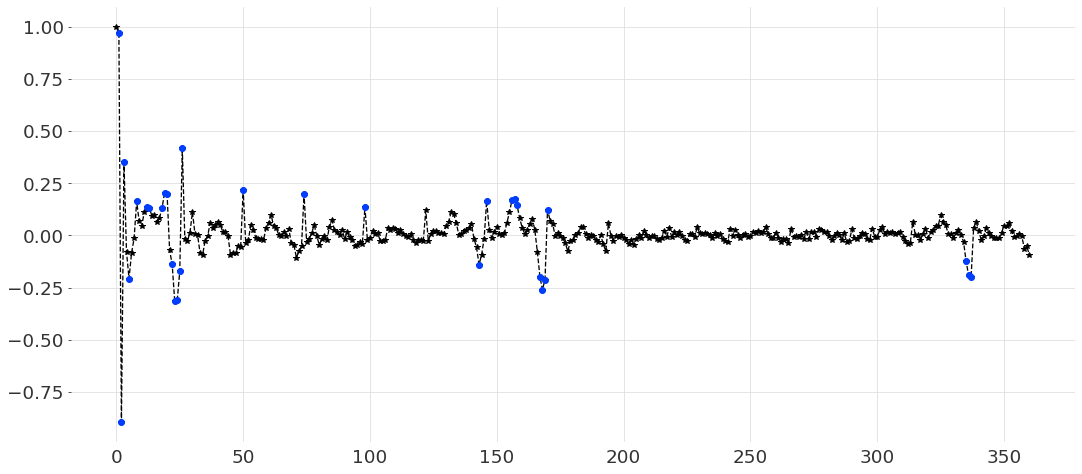

In [4]:
lags = estimateSignificantLags(data['Fact'], significantLags = 30)
# add lags for certain days
lags = np.unique(np.hstack([lags,[47,48,49,70,72,94,96,118,120,144]]))
print(np.sort(lags))

# Build a forecaster with lagged features

## Recursive forecaster class

- Works with models that use semantic ".fit(x,y), .predict(x,y)"
- Takes dataset as input, column to predict needs to be specified in "target" paremeter
- Adds lag features from an array of lags
- Creates prediciton for a set time horizon with frequency days, hours, and so on (needs to match the dataset)
- Each new prediction uses updated lags that contains previous predicted values for the set

In [5]:
class RecursiveForecaster():
    
    def __init__(self, data, target):
        self.x = data.drop(target, axis=1)
        self.y = data[target]

    def add_lag_features(self,lags):
        self.lags=lags
        for i in lags:
            self.x['lag_'+str(i)] = self.y.shift(i)    
            
    
    #def optimize(self, pred):
    #    self.cost_function
    
    #def fit(self):
        #we run our daily loops for valdation and call the optimizer
    
    def create_prediction(self, model_name,
                          start_day='2019-01-02', 
                          last_known_day='2019-12-01', 
                          prediction_day='2019-12-02',
                          frequency='D',
                          horizon=10):    
    
        X_train = self.x.loc[start_day:last_known_day]
        y_train = self.y.loc[start_day:last_known_day]
        
        model_name.fit(X_train,y_train)

        pred_index = pd.date_range(start=prediction_day, 
                                   periods=horizon, 
                                   freq=frequency)
        
        #print(pred_index)
        pred_df = pd.DataFrame(index=pred_index, 
                               columns=[self.y.name])
        
        #print(pred_df)
        #Create prediction for each time step in pred_index
        for step in pred_index:
            indx = str(step)#[:-9]
            #print(indx)
            X_pred = pd.DataFrame(self.x.loc[indx]).T
            #print(indx)
            x_index = self.x.loc[indx].name
            pred_df.loc[x_index] = model_name.predict(X_pred)
            
            #update features with lags containing lags of predicted value 
            for i in self.lags:
                self.x.loc[indx,'lag_'+str(i)] = pred_df.shift(i)

        return pred_df

## Example of use

In [6]:
tmp = RecursiveForecaster(data[['Fact']], 
                          target='Fact')

tmp.add_lag_features([1,2,3,4,5,7,9,15,27])

In [7]:
tmp.x

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_7,lag_9,lag_15,lag_27
Time,,,,,,,,,
2019-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02 01:00:00,9.791285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02 02:00:00,9.595427,9.791285,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02 03:00:00,9.538146,9.595427,9.791285,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02 04:00:00,9.420105,9.538146,9.595427,9.791285,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,12.577850,12.812850,13.067850,13.197850,13.21285,13.30285,13.32785,10.04285,13.44285
2019-12-31 20:00:00,12.082850,12.577850,12.812850,13.067850,13.19785,13.12785,13.39785,10.20285,13.21785
2019-12-31 21:00:00,11.582850,12.082850,12.577850,12.812850,13.06785,13.21285,13.30285,10.54785,12.95785


In [8]:
#model = linear_model.LinearRegression()

"""model = CatBoostRegressor(verbose=False,
                          learning_rate = 0.01, 
                          depth=6,
                          l2_leaf_reg=4)"""

#model = RandomForestRegressor()
model = lgb.LGBMRegressor()

pred = tmp.create_prediction(model,
                      start_day='2019-01-02',
                      last_known_day='2019-12-02',
                      prediction_day='2019-12-03',
                      frequency='H',
                      horizon=24)

## Plotting the results

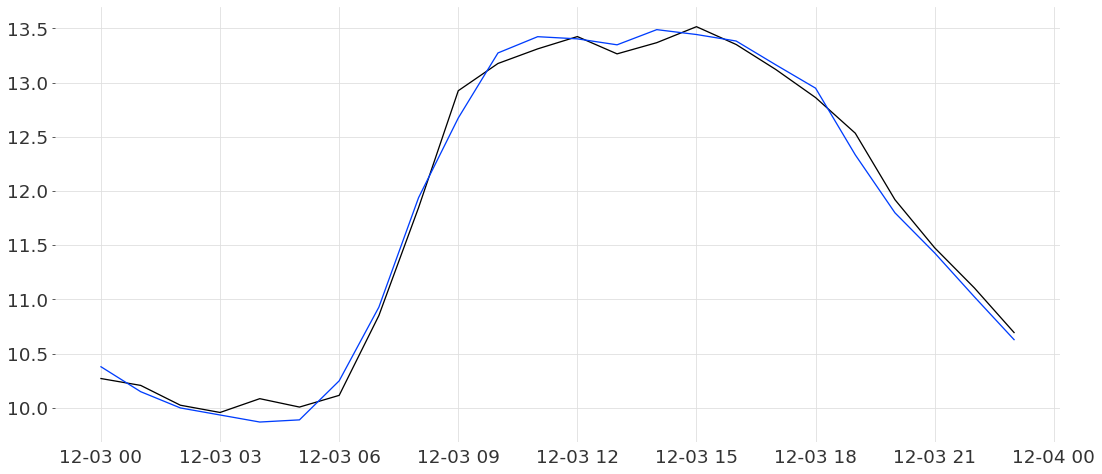

In [9]:
#pred.index = pred.index.astype('str')
plt.plot(pred)
plt.plot(tmp.y.loc[pred.index])

In [10]:
pred.head()

,Fact
2019-12-03 00:00:00,10.269048
2019-12-03 01:00:00,10.205851
2019-12-03 02:00:00,10.022939
2019-12-03 03:00:00,9.9561
2019-12-03 04:00:00,10.083383


In [11]:
def cost_function_capacity_constraint_margin(individual):

    cumsum = np.cumsum(individual) + batteryCharge
    violations_battery = (np.sum(np.where(cumsum>batteryCapacity)) + np.sum(np.where(cumsum<0))) * 10000
    
    tmp = demand+individual
    violations_demand = -np.sum(tmp[np.where(tmp<0)]) * 10000
    
    margin = (peakPowerLimit - (demand + individual))
    violations_peak = - np.sum(margin[np.where(margin < 0)]) * 1000

    batteryUsage = (1 - battery_efficiency) * np.sum(np.abs(individual)) * 1000
    
    return violations_battery + violations_demand + violations_peak + batteryUsage

In [15]:
# Define constraints and other boiler plate code

batteryCapacity = 150 # kWh
inverterCapacity = 80 #kW
battery_efficiency = .9
peakPowerLimit = 12 # kW

compBudget = 5000
timeHorizon = 96
days = 60
costs = np.zeros((days))
actions = np.zeros((days,24))

In [16]:
ng.p.Array(shape=(timeHorizon,)).set_bounds(lower=-inverterCapacity, upper=inverterCapacity)

Array{(96,),Cl(-80,80,b)}:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

# Capacity constraints

In [17]:
data.head()

,Prophet 30d,CB Model 30d,Prophet 60d,LR Model 240d,LR Model 30d,LR Model 60d,LR Model 120d,Prophet 120d,Theta 30d,Theta 60d,Theta 120d,Theta 240d,CB Model 60d,CB Model 240d,CB Model 120d,Prophet 240d,Fact,SNaive
Time,,,,,,,,,,,,,,,,,,
2019-01-02 00:00:00,9.712369,9.516061,9.732844,10.082039,10.034193,9.860739,9.931228,9.475604,9.992034,9.986460,10.074619,10.037784,9.478454,9.477245,9.469355,9.521947,9.791285,9.587180
2019-01-02 01:00:00,9.537794,9.329764,9.526740,9.905469,9.848606,9.685257,9.755594,9.250441,9.799050,9.784246,9.843274,9.809841,9.314212,9.310756,9.320833,9.283847,9.595427,9.421677
2019-01-02 02:00:00,9.346844,9.225298,9.357172,9.752310,9.685450,9.537204,9.604944,9.048528,9.646126,9.618324,9.656499,9.620984,9.217455,9.230141,9.192942,9.021519,9.538146,9.302606
2019-01-02 03:00:00,9.238202,9.140338,9.258282,9.633302,9.547768,9.422706,9.488390,8.965614,9.534998,9.506044,9.530117,9.501419,9.155913,9.161070,9.141137,8.909141,9.420105,9.151197
2019-01-02 04:00:00,9.222486,9.122567,9.222533,9.600721,9.502948,9.403288,9.459666,8.902531,9.499663,9.469673,9.476750,9.455269,9.125739,9.136762,9.136573,8.850692,9.364424,9.159970


# Optimizer to choose from several predictions

In [53]:
time_cut_off = pd.Timedelta(TIME_HORIZON,unit='H')
odm.x.index[-1:]-time_cut_off

DatetimeIndex(['2019-01-10 23:00:00'], dtype='datetime64[ns]', name='Time', freq=None)

In [134]:
class OptimalDecisionMakers(): 
    
    def __init__(self, data, target):
        self.x = data#.drop([target], axis=1)
        self.y = data[target]
    
    def select_value_optimal_model(self,
                                   optimizer,
                                   cost_function,
                                   decision_time_step,
                                   optimization_horizon,
                                   time_unit = 'H',
                                   random_seed=42,
                                   return_predictions=False):
        
        random.seed(random_seed)
        self.cost_function = cost_function
        self.optimal_decisions_df = pd.DataFrame(index=(self.x.index),columns=self.x.columns).iloc[:-optimization_horizon]

        for col in range(len(self.optimal_decisions_df.columns)):

            total_steps = range(0,len(self.x)-optimization_horizon,decision_time_step)
            recommendation = np.array([])

            for step in total_steps:
                
                par = ng.p.Array(shape=(TIME_HORIZON,)).set_bounds(lower=-80, upper=80)
                optimizer = ng.optimizers.CMA(parametrization=par, budget=5000)
                
                try:
                    self.candidate = self.x.iloc[step:step+optimization_horizon,col]
                except:
                    print(self.optimal_decisions_df.shape)
                    print(self.x.iloc[step:step+optimization_horizon,col])
                    
                step_recommendation = optimizer.minimize(cost_function)
                recommendation = np.append(recommendation,step_recommendation.value[0:decision_time_step])
                

            self.optimal_decisions_df.iloc[:,col] = recommendation
            

        return self.optimal_decisions_df
    
    def evaluate(self):
        
        for col in range(len(self.optimal_decisions_df.columns)):
            
            print(self.cost_function(self.optimal_decisions_df.iloc[:,col]))
        
    def select_value_optimal_hyperparameters():
        return

In [137]:
def cost_function(solution):
    cumsum = np.cumsum(solution) + BATTERY_CHARGE
    
    #battery capacity penalty:
    violations_battery = (np.sum(np.where(cumsum>BATTERY_CAPACITY)) + np.sum(np.where(cumsum<0))) * 10000
    
    #penalty for putting electricity back to the grid
    if EVALUATE:
        grid_load = (odm.y+solution).values
    else:
        grid_load = (odm.candidate+solution).values
    violations_demand = -np.sum(grid_load[np.where(grid_load<0)]) * 10000
    
    #penlty for high peak in load
    margin = (PEAK_POWER_LIMIT - grid_load)
    violations_peak = - np.sum(margin[np.where(margin < 0)]) * 1000
    
    #penalty for battery losses
    battery_usage = (1 - BATTERY_EFFICIENCY) * np.sum(np.abs(solution)) * 1000
    
    total_cost = violations_battery + violations_demand + violations_peak + battery_usage
    print(violations_battery,violations_demand,violations_peak,battery_usage)
    return total_cost

In [138]:
odm = OptimalDecisionMakers(pd.DataFrame(data.loc[data.index<'2019-01-15',['SNaive','LR Model 30d','Fact']]),'Fact')

EVALUATE = False
TIME_HORIZON = 96
DECISION_TIMESTEP = 24
PEAK_POWER_LIMIT = 12
BATTERY_CHARGE = 0
BATTERY_CAPACITY = 150
BATTERY_EFFICIENCY = .9

par = ng.p.Array(shape=(TIME_HORIZON,)).set_bounds(lower=-80, upper=80)
optimizer = ng.optimizers.CMA(parametrization=par, budget=10000)

sol = odm.select_value_optimal_model(optimizer,cost_function,decision_time_step=DECISION_TIMESTEP,optimization_horizon=TIME_HORIZON)

(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in dimension 96 (seed=nan, Sun Nov  7 22:01:48 2021)
(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in dimension 96 (seed=nan, Sun Nov  7 22:01:55 2021)
(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in dimension 96 (seed=nan, Sun Nov  7 22:02:01 2021)
(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in dimension 96 (seed=nan, Sun Nov  7 22:02:08 2021)
(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in dimension 96 (seed=nan, Sun Nov  7 22:02:14 2021)
(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in dimension 96 (seed=nan, Sun Nov  7 22:02:20 2021)
(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in dimension 96 (seed=nan, Sun Nov  7 22:02:27 2021)
(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in dimension 96 (seed=nan, Sun Nov  7 22:02:33 2021)
(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in dimension 96 (seed=nan, Sun Nov  7 22:02:40 2021)
(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in dimension 96 (seed=nan, Sun Nov  7 22:02:46 2021)
(8_w,17)-aCMA-ES (mu_w=5.1,w_1=31%) in dimension 96 (seed=nan, Sun Nov  7 22:02:53 2021)
(8_w,17)-aCMA-ES (mu_

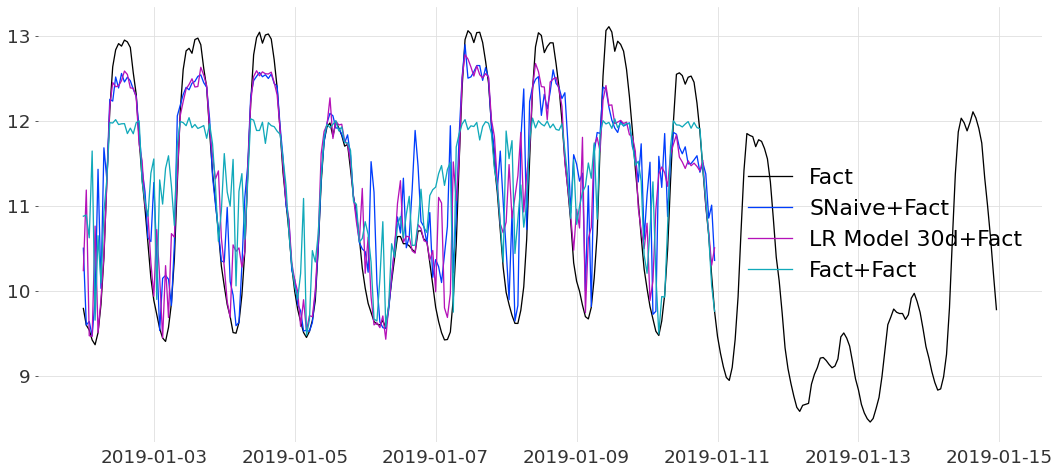

In [139]:
#plt.plot(sol.SNaive, label='solution')

plt.plot(odm.x.Fact, label='Fact')

plt.plot(sol.SNaive+odm.x.Fact, label='SNaive+Fact')
plt.plot(sol['LR Model 30d']+odm.x.Fact, label='LR Model 30d+Fact')

plt.plot(sol['Fact']+odm.x.Fact, label='Fact+Fact')
plt.legend()

In [143]:
EVALUATE = True
odm.evaluate()

34870.64322378825
33511.80508397219
14340.6140429332


In [141]:
cost_function(sol['SNaive']),cost_function(sol['LR Model 30d']),cost_function(sol['Fact'])

(34870.64322378825, 33511.80508397219, 14340.6140429332)

In [126]:
sol.head()

,SNaive,LR Model 30d,Fact
Time,,,
2019-01-02 00:00:00,1.344340,0.088309,0.856984
2019-01-02 01:00:00,0.190309,1.512033,1.772794
2019-01-02 02:00:00,1.192579,0.111995,0.706159
2019-01-02 03:00:00,0.091912,1.173384,0.328419
2019-01-02 04:00:00,-0.065346,-0.092977,0.832852


In [133]:
grid_load = (odm.x['Fact']+sol['SNaive']).values
margin = (PEAK_POWER_LIMIT - grid_load)
violations_peak = - np.sum(margin[np.where(margin < 0)]) * 1000
violations_peak

106.0413213917979